In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.integrate import cumtrapz

num_levels = 30
book_num = 1

file_loc_orderbooks = ["MSFT_2012-06-21_34200000_37800000_orderbook_50.csv","SPY_2012-06-21_34200000_37800000_orderbook_50.csv","AAPL_2012-06-21_34200000_37800000_orderbook_50.csv"]
file_loc_messages = ["MSFT_2012-06-21_34200000_37800000_message_50.csv","SPY_2012-06-21_34200000_37800000_message_50.csv","AAPL_2012-06-21_34200000_37800000_message_50.csv"]

file_loc_orderbook = file_loc_orderbooks[book_num]
file_loc_message = file_loc_messages[book_num]


def extract_column(file_loc,COL):
    return pd.read_csv(file_loc, index_col=None, na_values=['NA'], usecols=COL)

print(extract_column(file_loc_orderbook,[0]).shape,extract_column(file_loc_message,[0]).shape)

orderbook_df = pd.read_csv(file_loc_orderbook, index_col=None, na_values=['NA'])
orderbook_df = orderbook_df[orderbook_df.columns[:(num_levels*4)]]
message_df = pd.read_csv(file_loc_message, index_col=None, na_values=['NA'],usecols=[0])


limit_order_df = pd.concat([message_df.round(1),orderbook_df],axis=1)
limit_order_df.rename(columns={limit_order_df.columns[0]: "t"},inplace=True)
                      
for level in range(num_levels):
    
    bid_price_col, ask_price_col = f"bid_price_{level+1}",f"ask_price_{level+1}"
    bid_size_col, ask_size_col = f"bid_size_{level+1}", f"ask_size_{level+1}"
    
    limit_order_df.rename(columns={limit_order_df.columns[4*level+1]: ask_price_col, limit_order_df.columns[4*level+2]: ask_size_col,
                                   limit_order_df.columns[4*level+3]: bid_price_col, limit_order_df.columns[4*level+4]: bid_size_col}, inplace=True)
    
    limit_order_df[bid_price_col], limit_order_df[ask_price_col] = limit_order_df[bid_price_col] * (1.0/10000), limit_order_df[ask_price_col] * (1.0/10000)
                                   
    


print(limit_order_df)

(1154736, 1) (1154736, 1)
               t  ask_price_1  ask_size_1  bid_price_1  bid_size_1   
0        34200.0       135.65        3400       135.63        8800  \
1        34200.0       135.65        3400       135.63        8800   
2        34200.0       135.65        3400       135.63        8800   
3        34200.0       135.65        3400       135.63        8800   
4        34200.0       135.65        3400       135.63        8800   
...          ...          ...         ...          ...         ...   
1154731  37799.9       134.85        7193       134.84       11393   
1154732  37799.9       134.85        7193       134.84       11393   
1154733  37799.9       134.85        7193       134.84       11393   
1154734  37800.0       134.85        7093       134.84       11393   
1154735  37800.0       134.85        7093       134.84       11393   

         ask_price_2  ask_size_2  bid_price_2  bid_size_2  ask_price_3  ...   
0             135.66       17200       135.62       17

In [2]:


def compute_ofi(data, N_timestamps):
    """
    Compute Order Flow Imbalance (OFI) from limit order book (LOB) data.
    """
    bid_price, ask_price = data["bid_price_1"], data["ask_price_1"]
    bid_size, ask_size = data["bid_size_1"], data["ask_size_1"]

    bid_price_shift, ask_price_shift = bid_price.shift(1,fill_value=0), ask_price.shift(1,fill_value=0)
    bid_size_shift, ask_size_shift = bid_size.shift(1,fill_value=0), ask_size.shift(1,fill_value=0)

    data["ofi"] = 0
    
    data["ofi"] = ((bid_price >= bid_price_shift) * bid_size
         - (bid_price <= bid_price_shift) * bid_size_shift
         - (ask_price <= ask_price_shift) * ask_size
         + (ask_price >= ask_price_shift) * ask_size_shift)
    
    ofi_series = pd.Series(np.zeros(N_timestamps), index=data['t'].unique())
    
    for t in data['t'].unique():
        
        # sum all order flow imbalances during period dt
        ofi_series.loc[t] = data.loc[data['t'] == t, "ofi"].sum()
        
    return ofi_series

def compute_wmlofi(data, lambda_decay, num_levels, N_timestamps):
    """
    Compute Weighted Multi-Level Order flow Imbalance (WMLOFI)
    """
    
    num_levels = num_levels
    weights = np.exp(-lambda_decay * np.arange(num_levels))
    
    def select_columns(df, token):
        return [column for column in df.columns if column.startswith(token)]
    
    bid_prices, ask_prices = data[select_columns(data,"bid_price")], data[select_columns(data,"ask_price")]
    bid_sizes, ask_sizes = data[select_columns(data,"bid_size")], data[select_columns(data,"ask_size")]
    
    bid_prices_shift, ask_prices_shift = bid_prices.shift(1,fill_value=0), ask_prices.shift(1,fill_value=0)
    bid_sizes_shift, ask_sizes_shift = bid_sizes.shift(1,fill_value=0), ask_sizes.shift(1,fill_value=0)

    data["wmlofi"] = 0
    
    for level in range(1, num_levels + 1):
        
        bid_price_col, ask_price_col = f"bid_price_{level}",f"ask_price_{level}"
        bid_size_col, ask_size_col = f"bid_size_{level}", f"ask_size_{level}"
        
        data["wmlofi"] = data["wmlofi"] + weights[level-1] * (
            
            ((bid_prices[bid_price_col] >= bid_prices_shift[bid_price_col]) * bid_sizes[bid_size_col]
         - (bid_prices[bid_price_col] <= bid_prices_shift[bid_price_col]) * bid_sizes_shift[bid_size_col]
         - (ask_prices[ask_price_col] <= ask_prices_shift[ask_price_col]) * ask_sizes[ask_size_col]
         + (ask_prices[ask_price_col] >= ask_prices_shift[ask_price_col]) * ask_sizes_shift[ask_size_col] )
        )
    
    wmlofi_series = pd.Series(np.zeros(N_timestamps), index=data['t'].unique())
    
    for t in data['t'].unique():
        
        # sum all WMLOFI's during period dt
        wmlofi_series.loc[t] = data.loc[data['t'] == t, "wmlofi"].sum()
    
    return wmlofi_series
    
    

def compute_midprice(data, N_timestamps):
    
    midprice_series = pd.Series(np.zeros(N_timestamps), index=data['t'].unique())
    
    for t in data['t'].unique():
        
        k_timestamps = len(data.loc[data['t'] == t])
        
        # compute midprice during period by averaging over all prices
        midprice_series[t] = (0.5 / k_timestamps) *  (data.loc[data['t'] == t, "ask_price_1"].sum() + data.loc[data['t'] == t, "bid_price_1"].sum())
        
        # compute midprice by taking final bid and ask price
        #midprice_series[t] = (0.5) * (data.loc[data['t'] == t, "ask_price"].tail(1).item() + data.loc[data['t'] == t, "bid_price"].tail(1).item())
    
    return midprice_series
    

def compute_regression_terms(data):
    """
    Compute explanatory variables for the regression model.
    """
    
    N_timestamps = len(data['t'].unique())
    regress_cols = ['t','S0','S1','S2','S3','S4','midprice']
    lambda_decay = 0.05
                       
    regress_df = pd.DataFrame(np.zeros((N_timestamps,len(regress_cols))), columns=regress_cols)
    
    regress_df['t'] = data['t'].unique()
    regress_df['S0'] = 1
    regress_df['S1'] = data['t'].unique()
    #regress_df['S3'] = compute_ofi(data,N_timestamps).values
    regress_df['S3'] = compute_wmlofi(data,lambda_decay, num_levels, N_timestamps).values
    regress_df['midprice'] = compute_midprice(data,N_timestamps).values
    

    # Compute S2 and S4 using numerical integration (trapezoidal rule)
    regress_df["S2"] = np.zeros(len(regress_df))
    regress_df["S4"] = np.zeros(len(regress_df))
    for i in range(1, len(regress_df)):
        dt = regress_df['t'].iloc[i] - regress_df['t'].iloc[:i]
        weighted_ofi = regress_df['S3'].iloc[:i] * dt
        regress_df.at[regress_df.index[i], "S2"] = np.trapz(weighted_ofi, dt)
        regress_df.at[regress_df.index[i], "S4"] = np.trapz(regress_df["S3"].iloc[:i], dt)

    # Define regression variables
    return regress_df


def run_finite_population_regression(data):
    """
    Perform regression for the finite population model using OFI as order flow measure.
    """
    data = compute_regression_terms(data)
    
    X = data[["S0", "S1", "S2", "S3", "S4"]]
    y = data["midprice"]
    
    print(X)
    print(y)

    model = sm.OLS(y, X).fit()
    return model, data


result = run_finite_population_regression(limit_order_df)
print(result[0].summary())


/tmp/ipykernel_20093/1980486331.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["wmlofi"] = 0


       S0       S1            S2             S3            S4
0       1  34200.0  0.000000e+00   15607.665281  0.000000e+00
1       1  34200.1  0.000000e+00   53862.969642  0.000000e+00
2       1  34200.2 -4.253915e+02  -14533.689856 -3.473532e+03
3       1  34200.3 -1.238706e+03   85154.069383 -5.439996e+03
4       1  34200.4 -2.063139e+03  -98465.869612 -8.971015e+03
...    ..      ...           ...            ...           ...
28554   1  37799.6  5.006039e+09   -2621.651877  2.236132e+06
28555   1  37799.7  5.006263e+09  210951.299094  2.236339e+06
28556   1  37799.8  5.006486e+09 -193096.054548  2.225923e+06
28557   1  37799.9  5.006707e+09    1507.400164  2.225030e+06
28558   1  37800.0  5.006931e+09     416.693096  2.234610e+06

[28559 rows x 5 columns]
0        135.639495
1        135.634421
2        135.635000
3        135.639400
4        135.635513
            ...    
28554    134.845000
28555    134.852192
28556    134.849369
28557    134.845000
28558    134.845000
Name: midp

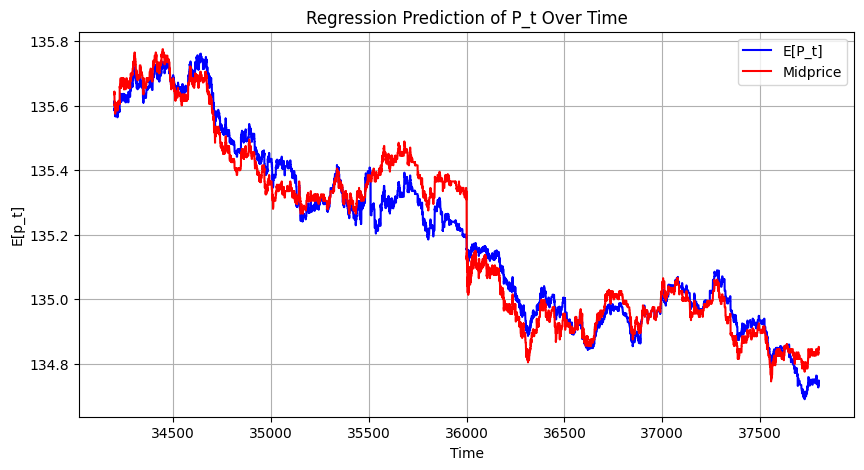

In [3]:

import matplotlib.pyplot as plt

# Predict p_t using the regression model
result[1]['E[P_t]'] = result[0].predict(result[1][["S0", "S1", "S2", "S3", "S4"]])

# Plot p_t against time
plt.figure(figsize=(10, 5))
plt.plot(result[1]["S1"], result[1]["E[P_t]"], label="E[P_t]", color="blue")
plt.plot(result[1]["S1"], result[1]['midprice'], label="Midprice", color="red")
plt.xlabel("Time")
plt.ylabel("E[p_t]")
plt.title("Regression Prediction of P_t Over Time")
plt.legend()
plt.grid()
plt.show()


In [4]:
result[1]

,t,S0,S1,S2,S3,S4,midprice,E[P_t]
0,34200.0,1,34200.0,0.000000e+00,15607.665281,0.000000e+00,135.639495,135.606908
1,34200.1,1,34200.1,0.000000e+00,53862.969642,0.000000e+00,135.634421,135.608063
2,34200.2,1,34200.2,-4.253915e+02,-14533.689856,-3.473532e+03,135.635000,135.607123
3,34200.3,1,34200.3,-1.238706e+03,85154.069383,-5.439996e+03,135.639400,135.610709
4,34200.4,1,34200.4,-2.063139e+03,-98465.869612,-8.971015e+03,135.635513,135.606364
...,...,...,...,...,...,...,...,...
28554,37799.6,1,37799.6,5.006039e+09,-2621.651877,2.236132e+06,134.845000,134.741657
28555,37799.7,1,37799.7,5.006263e+09,210951.299094,2.236339e+06,134.852192,134.747917
28556,37799.8,1,37799.8,5.006486e+09,-193096.054548,2.225923e+06,134.849369,134.739114
28557,37799.9,1,37799.9,5.006707e+09,1507.400164,2.225030e+06,134.845000,134.745150


In [5]:
print(result[1]['S3'].quantile(0.8))
print(result[1]['S3'].quantile(0.2))
result[1]['S3'].describe()

1531.194801639882
-1506.4119158928975


count    2.855900e+04
mean    -5.491082e+02
std      8.681399e+04
min     -1.429970e+06
25%     -9.953212e+02
50%      0.000000e+00
75%      1.011455e+03
max      1.140003e+06
Name: S3, dtype: float64

In [6]:
CASH_0 = 1000000.0
CASH = CASH_0
EQUITIES = 0

threshold = result[1]['S3'].quantile(0.8)
#threshold = 1000

LONG_POSITION = 0
ENTRY_PRICE = 0
EXIT_PRICE = 0

time_entry = 0

trade_duration = np.array([])
    
for i in range(len(result[1])):
    
    if result[1].loc[i,'S3'] > -5 * threshold:
        if CASH - 1000 * result[1].loc[i,'midprice'] > 0 and LONG_POSITION < 1000:
            
            LONG_POSITION = 1000
            ENTRY_PRICE = result[1].loc[i,'midprice']
            CASH = CASH - ENTRY_PRICE * LONG_POSITION
            EQUITIES = ENTRY_PRICE * LONG_POSITION
            #print(LONG_POSITION, CASH, EQUITIES, CASH + EQUITIES)
            
            time_entry = result[1].loc[i,'t']
            
    
    if result[1].loc[i,'S3'] < 5 * threshold:
        if LONG_POSITION == 1000:
            
            EXIT_PRICE = result[1].loc[i,'midprice']
            CASH = CASH + EXIT_PRICE * LONG_POSITION
            LONG_POSITION = 0
            EQUITIES = 0
            #print(LONG_POSITION, CASH, EQUITIES, CASH + EQUITIES)

            trade_duration = np.append(trade_duration,result[1].loc[i,'t'] - time_entry)
    
print(len(result[1]))
        
    
            
      
print(CASH, EQUITIES, CASH + EQUITIES)
print(CASH + EQUITIES - CASH_0)
print(result[1].loc[0,'midprice'] * 1000)
return_T = (CASH + EQUITIES - CASH_0) / (result[1].loc[0,'midprice'] * 1000)
print("RETURN: " + str(round((100 * return_T),2)) + str("%"))
print()
print(pd.DataFrame(trade_duration).describe())
print("Average Trade Duration: " + str(round((trade_duration.mean()),)) + str(" seconds."))




    

28559
1004857.4880224932 0 1004857.4880224932
4857.4880224931985
135639.49541284403
RETURN: 3.58%

                  0
count  24499.000000
mean       0.009086
std        0.034770
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.700000
Average Trade Duration: 0 seconds.
